# Constrained Optimal Transport

This notebook provides a tutorial on using the {class}`OTT's <ott.solvers.linear.sinkhorn.Sinkhorn>` to solve constrained optimal transport (COT) problems. The tutorial heavily relies on the paper {cite}`tang:24` and the ott-jax package.

## Packages Import

In [336]:
from dataclasses import dataclass
from typing import Any, Optional, Tuple

from tqdm import trange

import jax
import jax.numpy as jnp
import numpy as np
from jaxopt import ScipyMinimize

import matplotlib.pyplot as plt

from ott.geometry import costs, pointcloud
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers import linear

## Utils

In [321]:
def plot_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Optimization History", fontsize=16)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # Plot cost
    axes[0, 0].plot(history["cost"], label="Cost", color="blue")
    axes[0, 0].set_title("Cost")
    axes[0, 0].set_xlabel("Iteration")
    axes[0, 0].set_ylabel("Value")

    # Plot constraint violation
    axes[0, 1].plot(history["violation"], label="Violation", color="red")
    axes[0, 1].set_title("Constraint Violation")
    axes[0, 1].set_xlabel("Iteration")
    axes[0, 1].set_ylabel("Violation")

    # Plot Total Variation (TV)
    axes[1, 0].plot(history["TV"], label="Total Variation", color="green")
    axes[1, 0].set_title("Total Variation (TV)")
    axes[1, 0].set_xlabel("Iteration")
    axes[1, 0].set_yscale("log")
    axes[1, 0].set_ylabel("TV Distance")

    # Plot norm of P (or visual indicator)
    P_norms = [np.linalg.norm(P) for P in history["P"]]
    axes[1, 1].plot(P_norms, label="‖P‖", color="purple")
    axes[1, 1].set_title("Transport Plan Norm (‖P‖)")
    axes[1, 1].set_xlabel("Iteration")
    axes[1, 1].set_ylabel("Frobenius Norm")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Constrained Linear Problem (CLP)

Given $a, b \in \mathbb{R}^n$, a cost matrix $C \in \mathbb{R}^{n \times n}$, and matrices $D_1, \dots, D_K, D_{K+1}, \dots, D_{K+L} \in \mathbb{R}^{n \times n}$, the corresponding constrained optimal transport problem (COT) is formulated as:

$$
\min_{P \in \mathcal{U}(a, b)} \langle C, P \rangle \quad \text{subject to} \quad 
\begin{array}{cc}
\forall k = 1, \dots, K & \langle D_k, P \rangle \geq 0 \\
\forall l = 1, \dots, L & \langle D_{K+l}, P \rangle = 0
\end{array}
$$

Where:
- $ \mathcal{U}(a, b) $ is the set of transport plans $ P $ such that $ P1 = a $ and $ P^T1 = b $ (i.e., the marginals are fixed),
- $ \langle C, P \rangle $ represents the inner product between the cost matrix $C$ and the transport plan $P$, which is computed as $ \sum_{i,j} C_{ij} P_{ij} $,
- $ D_k $ are matrices representing **non-negativity** constraints on the transport plan (i.e., $ \langle D_k, P \rangle \geq 0 $ for $ k = 1, \dots, K $),
- $ D_{K+l} $ are matrices representing **equality** constraints on the transport plan (i.e., $ \langle D_{K+l}, P \rangle = 0 $ for $ l = 1, \dots, L $).

### Core Attributes of Constrained Linear Problem (CLP)

The core attributes of the constrained linear problem are implemented in the `ConstrainedLinearProblem` class. The class utilizes the `Geometry` class to define the cost matrix and the underlying geometry of the problem.

#### Key Attributes:

- **`a` (jnp.array)**: The first marginal distribution $a $ with shape $ (n,) $.
- **`b` (jnp.array)**: The second marginal distribution $ b $ with shape $ (n,) $.
- **`geom` (Geometry)**: An object that encapsulates the geometry (e.g., distance or structure) of the problem. This can include additional information, such as the cost matrix $ C $.
- **`constraints` (jnp.array, optional)**: The constraint matrices $ D_1, \dots, D_K, D_{K+1}, \dots, D_{K+L} $, typically of shape $ (n, n, K+L) $, specifying linear constraints on the transport matrix.

This class provides methods to:
- Round an approximate transport matrix to ensure it lies in the feasible set $ \mathcal{U}(a, b) $.
- Compute the cost of an approximate transport plan, taking into account the cost matrix.

In [ ]:
class ConstrainedLinearProblem:
    """
    This class implements a constrained linear problem with a cost matrix,
    constraints, and a regularization parameter epsilon. It provides methods
    to round an approximate transport matrix to ensure it lies in the set U(a,b)
    and to compute the cost of an approximate transport plan.

    Attributes:
        a (jnp.array): distribution a of shape (n,)
        b (jnp.array): distribution b of shape (n,)
        epsilon (float): regularization parameter
        cost_matrix (jnp.array): cost matrix of shape (n,n)
        constraints (jnp.array): constraints for the transport problem of shape (n,n,K+L)

    Methods:
        round(F: jnp.array) -> jnp.array:
            Round an approximate transport matrix F to ensure it lies in
            the set U(a,b)={F: F1=a, F^T1=b, F>=0}.
        cost(P: jnp.array) -> jnp.array:
            Compute the cost of an approximate transport plan P.
    """

    def __init__(
        self,
        geom: Geometry,
        a: jnp.array,
        b: jnp.array,
        constraints: jnp.array,
        K: int,
    ):
        self.a = a
        self.b = b
        self.geom = geom
        self.constraints = constraints
        self.K = K

    def round(self, F: jnp.array) -> jnp.array:
        """Round an approximate transport matrix F to ensure it lies in
        the set U(a,b)={F: F1=a, F^T1=b, F>=0}.

        Args:
            F (jnp.array): approximate transport matrix of shape (n,n)

        Returns:
            jnp.array: rounded transport matrix lying in U(a,b)
        """
        X = jnp.diag(jnp.minimum(self.a / jnp.sum(F, axis=1), 1))
        F = X @ F
        Y = jnp.diag(jnp.minimum(self.b / jnp.sum(F, axis=0), 1))
        F = F @ Y
        err_a, err_b = self.a - jnp.sum(F, axis=1), self.b - jnp.sum(F, axis=0)
        return F + jnp.outer(err_a, err_b) / jnp.sum(err_a)

    def cost(self, P: jnp.array) -> jnp.array:
        """Compute the cost of an approximate transport plan P.

        Args:
            P (jnp.array): approximate transport plan of shape (n,n)

        Returns:
            jnp.array: cost of the transport plan
        """
        return jnp.sum(self.geom.cost_matrix * self.round(P))

    def violation(self, P: jnp.array) -> jnp.array:
        """Compute total constraint violation of approximate transport plan P."""
        P_rounded = self.round(P)
        constraint_values = jnp.einsum("ij,ijk->k", P_rounded, self.constraints)

        ineq_violation = jnp.sum(
            jnp.abs(jnp.minimum(constraint_values[: self.K], 0.0))
        )
        eq_violation = jnp.sum(jnp.abs(constraint_values[self.K :]))

        return eq_violation + ineq_violation

## Entropic Relaxation

Motivated by the results in {cite}`tang:24`, we solve an entropic relaxation of the Constrained Optimal Transport (COT) problem. This relaxation provides an exponentially close solution to the original COT problem. The entropic relaxation is formulated as follows:

$$
\min_{P \in \mathcal{U}(a, b), \, s \in \mathbb{R}_+^K}  \langle C, P \rangle + \varepsilon H(P, s_1, \dots, s_K)  \quad \text{subject to} \quad 
\begin{array}{cc}
\forall k = 1, \dots, K & \langle D_k, P \rangle = s_k \\
\forall l = 1, \dots, L & \langle D_{K+l}, P \rangle = 0
\end{array}
$$

Here, $ H(P, s_1, \dots, s_K) $ represents the entropy regularization term for a transport plan $P$ and scalars $s_1, \dots, s_K$, which is computed as $H(P, s_1, \dots, s_K) = \sum_{1 \leq i,j \leq n} P_{ij} \log P_{ij} + \sum_{k=1}^{K} s_k \log s_k$.

### Primal-Dual Formulation

The corresponding primal-dual formulation of the entropic relaxation is:

$$
\max_{u, v \in \mathbb{R}^n; \, h \in \mathbb{R}^{K+L}} \min_{P, s} \mathcal{L}_\varepsilon (u, v, h; P, s)
$$

where the Lagrangian $ \mathcal{L}_\varepsilon  $ is defined as:

$$
\mathcal{L}_\varepsilon (u, v, h; P, s) := \varepsilon \langle P, \log P \rangle + \langle C, P \rangle - \langle u, P\mathbf{1} - a \rangle - \langle v, P^T\mathbf{1} - b \rangle + \varepsilon \sum_{k=1}^K s_k \log s_k + \sum_{k=1}^K h_k s_k + \sum_{m=1}^{K+L} h_m \langle D_m, P \rangle
$$

We define the Lyapunov function as:

$$
f(u, v, h) = \min_{P, s} \mathcal{L}_\varepsilon (u, v, h; P, s).
$$

The corresponding intermediate transport plan $ P_\varepsilon(u, v, h) $ is given by:

$$
P_\varepsilon (u,v,h) = \exp \left( \frac{1}{\varepsilon} \left( -C + \sum_{m=1}^{K+L} h_m D_m + u \mathbf{1}^T + \mathbf{1} v^T \right) - 1 \right).
$$

The Lyapunov function $ f(u, v, h) $ has the following explicit formulation:

$$
f(u, v, h) = -\varepsilon \sum_{1 \leq i, j \leq n} \exp \left( \frac{1}{\varepsilon} \left( -C_{ij} + \sum_{m=1}^{K+L} h_m (D_m)_{ij} + u_i + v_j \right) - 1 \right)
+ \sum_{i=1}^n u_i a_i + \sum_{j=1}^n v_j b_j - \varepsilon \sum_{k=1}^K \exp \left( - \frac{1}{\varepsilon} h_k - 1 \right)
$$

By the minimax theorem, solving the entropic relaxation problem is equivalent to maximizing $f$. After maximizing for $(u, v, h)$, the corresponding optimal transport plan $ P_\varepsilon^* $ is a smoothed approximation of the original transport matrix $P^*$. As $\varepsilon \to 0$, the solution $ P_\varepsilon^*$ converges to the optimal solution of the original CLP problem.

### Constrained Sinkhorn Solver

The `ConstrainedSinkhornSolver` class is an implementation of the Sinkhorn algorithm tailored for regularized optimal transport with additional constraints. It is designed to solve constrained linear problem (CLP) problems. 

The algorithm iteratively computes a transport plan that satisfies the marginal constraints (given by `a` and `b`) while minimizing the transportation cost subject to the constraints. The solver utilizes both Sinkhorn scaling steps and Newton steps.


In [292]:
class ConstrainedSinkhornSolver:

    def __init__(
        self,
        cot_lp,
        max_iter=20,
        tol=1e-3,
        store_history=True,
        u_init=None,
        v_init=None,
        h_init=None,
    ):
        self.cot_lp = cot_lp
        self.max_iter = max_iter
        self.tol = tol
        self.store_history = store_history

        self.n = cot_lp.a.shape[0]
        self.K = cot_lp.K
        self.epsilon = cot_lp.geom.epsilon
        self.constraints = cot_lp.constraints
        self.h_dim = self.constraints.shape[2]

        self.u = u_init if u_init is not None else jnp.zeros(self.n)
        self.v = v_init if v_init is not None else jnp.zeros(self.n)
        self.h = h_init if h_init is not None else jnp.zeros(self.h_dim)

        if self.store_history:
            self.history = {"cost": [], "violation": [], "P": [], "TV": []}

    def compute_transport(self, u, v, h):
        modulation = (
            jnp.tensordot(self.constraints, h, axes=([2], [0])) / self.epsilon
        )
        base = self.cot_lp.geom.transport_from_potentials(u, v)
        return base * jnp.exp(modulation - 1)

    def scaling_step(self, u, v, h, axis):
        P = self.compute_transport(u, v, h)
        marg = jnp.sum(P, axis=axis)
        target = self.cot_lp.a if axis == 1 else self.cot_lp.b
        return self.epsilon * (jnp.log(target) - jnp.log(marg))

    def lyapunov(self, u, v, h):
        P = self.compute_transport(u, v, h)
        dual_u = jnp.sum(u * self.cot_lp.a)
        dual_v = jnp.sum(v * self.cot_lp.b)
        dual_h = -self.epsilon * jnp.sum(
            jnp.exp(-(1 / self.epsilon) * h[: self.K] - 1)
        )
        return -self.epsilon * jnp.sum(P) + dual_u + dual_v + dual_h

    def newton_step(self, u, v):
        def objective(w):
            u_shifted = u + w[0] * jnp.ones_like(u)
            return -self.lyapunov(u_shifted, v, w[1:])

        w0 = jnp.zeros(self.h_dim + 1)

        solver = ScipyMinimize(
            fun=objective,
            method="Newton-CG",
            maxiter=100,
            tol=1e-6,
        )
        return solver.run(w0)

    def compute_cost_and_violation(self, transport):
        rounded = self.cot_lp.round(transport)
        cost = self.cot_lp.cost(rounded)
        violation = self.cot_lp.violation(rounded)
        return cost, violation

    def solve(self):
        for _ in trange(self.max_iter, desc="Sinkhorn Epochs"):
            transport_old = self.compute_transport(self.u, self.v, self.h)

            self.u += self.scaling_step(self.u, self.v, self.h, axis=1)
            self.v += self.scaling_step(self.u, self.v, self.h, axis=0)
            w, info = self.newton_step(self.u, self.v)
            self.h += w[1:]
            self.u += w[0] * jnp.ones_like(self.u)

            transport = self.compute_transport(self.u, self.v, self.h)

            total_variation = 0.5 * jnp.sum(jnp.abs(transport - transport_old))

            if self.store_history:
                cost, violation = self.compute_cost_and_violation(transport)
                self.history["cost"].append(cost)
                self.history["violation"].append(violation)
                self.history["P"].append(transport)
                self.history["TV"].append(total_variation)

            if total_variation < self.tol:
                break

        return self.compute_transport(self.u, self.v, self.h)

    def get_history(self):
        return self.history

## Numerical Experiments

### Random Assignment Problem 

We reproduce the first experiment of {cite}`tang:24`. The source and target densities are set $a=b=\frac{1}{n}\mathbf{1}_n$ and the entries of the cost matrix $C$, the inequality constraint matrix $D_I$ and the equality constraint matrix $D_E$ are drawn from $\mathcal{U}(0,1)$. Given two thresholds $t_I$ and $t_E$ we consider the following problem:

$$
\min_{P \in \mathcal{U}(a, b)} \langle C, P \rangle \quad \text{subject to} \quad 
\begin{array}{c}
\langle D_I, P \rangle \leq t_I \\
\langle D_E, P \rangle = t_E
\end{array}
$$

Given that $P\mathbf{1}_n=a= \frac{1}{n}\mathbf{1}_n$ and $P^T\mathbf{1}_n=b=\frac{1}{n}\mathbf{1}_n$, we can rewrite the constraints as $\left\{\begin{array}{c}
\langle t_I\mathbf{1}_{n\times n} - D_I, P \rangle \geq 0 \\
\langle D_E - t_E\mathbf{1}_{n\times n}, P \rangle = 0
\end{array}\right.$.


In [ ]:
def generate_random_assignment(n=500, tI=0.5, tE=0.5, seed=42):
    rng = np.random.default_rng(seed)

    C = rng.uniform(0, 1, size=(n, n))
    DI = rng.uniform(0, 1, size=(n, n))
    DE = rng.uniform(0, 1, size=(n, n))

    D1 = (DI - tI) / n
    D2 = (DE - tE) / n

    return C, D1, D2

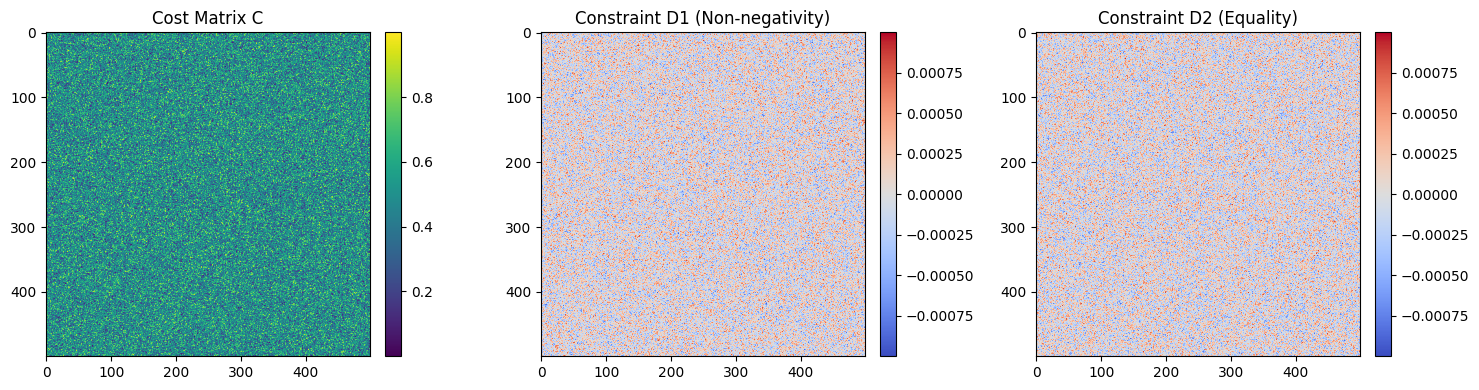

In [390]:
# Generate problem
C, D1, D2 = generate_random_assignment(n=500, seed=10)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im0 = axs[0].imshow(C, cmap="viridis")
axs[0].set_title("Cost Matrix C")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(D1, cmap="coolwarm")
axs[1].set_title("Constraint D1 (Non-negativity)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(D2, cmap="coolwarm")
axs[2].set_title("Constraint D2 (Equality)")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
cot_lp = ConstrainedLinearProblem(
    a=jnp.ones(C.shape[0]) / C.shape[0],
    b=jnp.ones(C.shape[1]) / C.shape[1],
    constraints=jnp.stack([D1, D2], axis=2),
    K=1,
    geom=Geometry(
        cost_matrix=C, epsilon=1 / 1200
    ),  # epsilon is set to :math:`0.05 * \text{stddev(cost_matrix)}`
)

The choice of `epsilon` has a substantial impact on both the computational speed, the convergence properties and the numerical stability of the algorithm.

In [324]:
solver = ConstrainedSinkhornSolver(
    cot_lp=cot_lp,
    max_iter=200,
    tol=1e-4,
    store_history=True,
    u_init=jnp.zeros(cot_lp.a.shape[0]),
    v_init=jnp.zeros(cot_lp.b.shape[0]),
    h_init=jnp.zeros(cot_lp.constraints.shape[2]),
)
solver.solve()
history = solver.get_history()

Sinkhorn Epochs: 100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


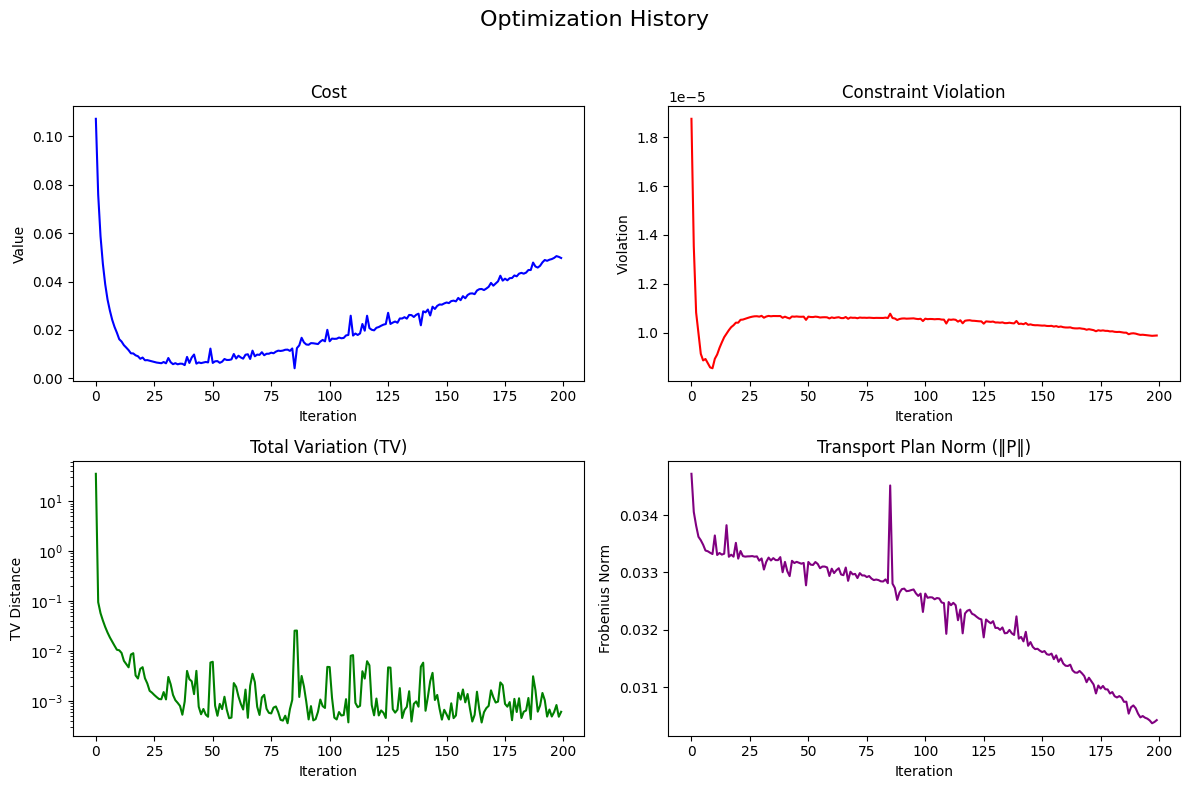

In [322]:
plot_history(history)

Cost and Constraints violation metric are not monotone. It may be because of numerical instability in the computation of the lyapunov function.

### Pareto front for geometric transport problem under Euclidean distance and Manhattan distance